# Captcha is commonly used to tell computers and humans apart. The main task of this project is to 
1. generate captcha numerical images with background noises and distorted numbers. 
2. preprocess the image data(change rgb2 gray, normalization, )
3. build model with cnn
4. deploy the service to the website

1. generate captcha images with package(pillow and captcha)

In [77]:
# import packages
from captcha.image import ImageCaptcha

import random
import numpy as np

import matplotlib.pyplot as plt
import PIL.Image as Image


from keras import backend as K
from keras.utils.vis_utils import plot_model
from keras.models import *
from keras.layers import *

import glob
import pickle
import os

In [104]:
# parameters
NUMBER = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
LOWERCASE = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
            'v', 'w', 'x', 'y', 'z']
UPPERCASE = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U',
           'V', 'W', 'X', 'Y', 'Z']

CAPTCHA_CHARSET = NUMBER   
CAPTCHA_LEN = 4            
CAPTCHA_HEIGHT = 60        
CAPTCHA_WIDTH = 160        


TRAIN_DATASET_SIZE = 5000   
TEST_DATASET_SIZE = 100
TRAIN_DATA_DIR = './train-data/' 
TEST_DATA_DIR = './test-data/'

BATCH_SIZE = 100
EPOCHS = 4
OPT = 'adam'
LOSS = 'binary_crossentropy'

MODEL_DIR = './model/train_demo/'
MODEL_FORMAT = '.h5'
HISTORY_DIR = './history/train_demo/'
HISTORY_FORMAT = '.history'

filename_str = "{}captcha_{}_{}_bs_{}_epochs_{}{}"
MODEL_FILE = filename_str.format(MODEL_DIR, OPT, LOSS, str(BATCH_SIZE), str(EPOCHS), MODEL_FORMAT)
HISTORY_FILE = filename_str.format(HISTORY_DIR, OPT, LOSS, str(BATCH_SIZE), str(EPOCHS), HISTORY_FORMAT)

In [88]:
# generate train_data_set

# generate single data
def gen_random_text(charset=CAPTCHA_CHARSET, length=CAPTCHA_LEN):
    text = [random.choice(charset) for _ in range(length)]
    return ''.join(text)

# generate data set
def create_captcha_dataset(size, dataset_dir, height=CAPTCHA_HEIGHT, width=CAPTCHA_WIDTH, image_format='.png'):
    if not os.path.exists(dataset_dir):
        os.makedirs(dataset_dir)
    captcha = ImageCaptcha(width = width, height=height)
    
    for _ in range(size):
        text = gen_random_text()
        captcha.write(text, dataset_dir+text+image_format)
    return None


In [89]:
create_captcha_dataset(TRAIN_DATASET_SIZE, TRAIN_DATA_DIR)
create_captcha_dataset(TEST_DATASET_SIZE, TEST_DATA_DIR)

In [90]:
# plot and check
def gen_captcha_dataset(size=100,
                        height=60,                           
                        width=160,
                        image_format='.png'):
    captcha = ImageCaptcha(width=width, height=height)
    images, texts = [None]*size, [None]*size
    for i in range(size):
        texts[i] = gen_random_text(CAPTCHA_CHARSET, CAPTCHA_LEN)
        images[i] = np.array(Image.open(captcha.generate(texts[i])))
        
    return images, texts



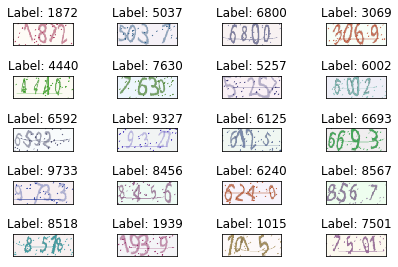

In [41]:
images, texts = gen_captcha_dataset()
plt.figure()
for i in range(20):
    plt.subplot(5,4,i+1) 
    plt.tight_layout() 
    plt.imshow(images[i])
    plt.title("Label: {}".format(texts[i])) 
    plt.xticks([]) 
    plt.yticks([]) 
plt.show()



In [43]:
images[0].shape

(60, 160, 3)

In [46]:
texts[0]

'1872'

2. preprocessing image data

In [62]:
def rgb2gray(img):
    # Y' = 0.299 R + 0.587 G + 0.114 B 
    return np.dot(img[...,:3], [0.299, 0.587, 0.114])

In [63]:
def text2vec(text, length=CAPTCHA_LEN, charset=CAPTCHA_CHARSET):
    '''return (captcha_len * captcha_charset_len) one hot'''
    text_len = len(text)
    
    if text_len != length:
        raise ValueError('Error: length of captcha should be {}, but got {}'.format(length, text_len))

    vec = np.zeros(length * len(charset))
    for i in range(length):
        vec[charset.index(text[i]) + i*len(charset)] = 1
    return vec


In [64]:
def vec2text(vector):
    if not isinstance(vector, np.ndarray):
        vector = np.asarray(vector)
    vector = np.reshape(vector, [CAPTCHA_LEN, -1])
    text = ''
    for item in vector:
        text += CAPTCHA_CHARSET[np.argmax(item)]
    return text

In [65]:
def fit_keras_channels(batch, rows=CAPTCHA_HEIGHT, cols=CAPTCHA_WIDTH):
    if K.image_data_format() == 'channels_first':
        batch = batch.reshape(batch.shape[0], 1, rows, cols)
        input_shape = (1, rows, cols)
    else:
        batch = batch.reshape(batch.shape[0], rows, cols, 1)
        input_shape = (rows, cols, 1)
    
    return batch, input_shape

In [92]:
X_train = []
Y_train = []
for filename in glob.glob(TRAIN_DATA_DIR + '*.png'):
    X_train.append(np.array(Image.open(filename)))
    Y_train.append(filename.lstrip(TRAIN_DATA_DIR).rstrip('.png'))

In [93]:
# list -> rgb(numpy)
X_train = np.array(X_train, dtype=np.float32)
# rgb -> gray
X_train = rgb2gray(X_train)
# normalize
X_train = X_train / 255
# Fit keras channels
X_train, input_shape = fit_keras_channels(X_train)

print(X_train.shape, type(X_train))
print(input_shape)

(3913, 60, 160, 1) <class 'numpy.ndarray'>
(60, 160, 1)


In [94]:
Y_train = list(Y_train)

for i in range(len(Y_train)):
    Y_train[i] = text2vec(Y_train[i])

Y_train = np.asarray(Y_train)

print(Y_train.shape, type(Y_train))



(3913, 40) <class 'numpy.ndarray'>


In [100]:


X_test = []
Y_test = []
for filename in glob.glob(TEST_DATA_DIR + '*.png'):
    X_test.append(np.array(Image.open(filename)))
    Y_test.append(filename.lstrip(TEST_DATA_DIR).rstrip('.png'))

# list -> rgb -> gray -> normalization -> fit keras 
X_test = np.array(X_test, dtype=np.float32)
X_test = rgb2gray(X_test)
X_test = X_test / 255
X_test, _ = fit_keras_channels(X_test)

Y_test = list(Y_test)
for i in range(len(Y_test)):
    Y_test[i] = text2vec(Y_test[i])

Y_test = np.asarray(Y_test)

print(X_test.shape, type(X_test))
print(Y_test.shape, type(Y_test))



(99, 60, 160, 1) <class 'numpy.ndarray'>
(99, 40) <class 'numpy.ndarray'>


3. build cnn model

In [110]:
def customerAcc(y_true, y_pred):
    batch_size = y_true.shape[0]
    y_pred = y_pred.reshape(batch_size, 4, 10)
    y_true = y_true.reshape(batch_size, 4, 10)
    
    true_pred = K.sum(K.round(K.clip(y_pred, 0 ,1)), -1)
    true_positive = K.sum(K.round(K.clip(y_pred * y_true, 0 ,1)), -1)
    true_y = K.sum(K.round(K.clip(y_true,0,1)), -1)
    accuracy = K.sum((true_positive == true_y and true_pred == true_y), -1)
    accuracy = K.mean(accuracy==4)
    return accuracy
    
    

In [128]:
inputs = Input(shape = input_shape, name = "inputs")

conv1 = Conv2D(32, (3, 3), name = "conv1")(inputs)
relu1 = Activation('relu', name="relu1")(conv1)

conv2 = Conv2D(32, (3, 3), name = "conv2")(relu1)
relu2 = Activation('relu', name="relu2")(conv2)
pool2 = MaxPooling2D(pool_size=(2,2), padding='same', name="pool2")(relu2)

conv3 = Conv2D(64, (3, 3), name = "conv3")(pool2)
relu3 = Activation('relu', name="relu3")(conv3)
pool3 = MaxPooling2D(pool_size=(2,2), padding='same', name="pool3")(relu3)


x = Flatten()(pool3)


x = Dropout(0.25)(x)


x = [Dense(10, activation='softmax', name='fc%d'%(i+1))(x) for i in range(4)]


outs = Concatenate()(x)

model = Model(inputs=inputs, outputs=outs)
model.compile(optimizer=OPT, loss=LOSS, metrics=['accuracy'] )


In [96]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 60, 160, 1)] 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 58, 158, 32)  320         inputs[0][0]                     
__________________________________________________________________________________________________
relu1 (Activation)              (None, 58, 158, 32)  0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 56, 156, 32)  9248        relu1[0][0]                      
_______________________________________________________________________________________

In [130]:
history = model.fit(X_train,
                    Y_train,
                    batch_size=BATCH_SIZE,
                    epochs=2,
                    verbose=2,
                    validation_data=(X_test, Y_test))

Epoch 1/2
40/40 - 120s - loss: 0.3234 - accuracy: 0.0222 - val_loss: 0.3217 - val_accuracy: 0.0808
Epoch 2/2
40/40 - 147s - loss: 0.2995 - accuracy: 0.2047 - val_loss: 0.2841 - val_accuracy: 0.2828


In [131]:
# save modelif not os.path.exists(dataset_dir):
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

model.save(MODEL_FILE)
print('Saved trained model at %s ' % MODEL_FILE)

Saved trained model at ./model/train_demo/captcha_adam_binary_crossentropy_bs_100_epochs_4.h5 


In [132]:
# save history
if not os.path.exists(HISTORY_DIR):
    os.makedirs(HISTORY_DIR)
with open(HISTORY_FILE, 'wb') as f:
    pickle.dump(history.history, f)

4. deploy the service to the website

we write this part of code in a new python file.